### Part 3

#### Preparation

In [1]:
# Helper code session (Copied from pokedex_helper):
!pip install datasets transformers numpy pandas Pillow matplotlib 
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7e6ue96z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7e6ue96z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [3]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]
            
    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neåighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [4]:
# Part 3 dataset download

! pip install -q kaggle
import kagglehub
path = kagglehub.dataset_download("hlrhegemony/pokemon-image-dataset")
print("Path to dataset files:", path)
!wget -O Pokemon.csv https://raw.githubusercontent.com/lgreski/pokemonData/master/Pokemon.csv


Using Colab cache for faster access to the 'pokemon-image-dataset' dataset.
Path to dataset files: /kaggle/input/pokemon-image-dataset
--2026-02-11 23:11:01--  https://raw.githubusercontent.com/lgreski/pokemonData/master/Pokemon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74060 (72K) [text/plain]
Saving to: ‘Pokemon.csv’

Pokemon.csv         100%[===================>]  72.32K  --.-KB/s    in 0.001s  

2026-02-11 23:11:02 (51.3 MB/s) - ‘Pokemon.csv’ saved [74060/74060]



In [5]:
# Part 3 Dataset read
IMAGE_ROOT = "/kaggle/input/pokemon-image-dataset/images"

pokedex = construct_pokedex(
    csv_path="Pokemon.csv",
    image_dir=IMAGE_ROOT, # path of download, should be modified, see output of Path to dataset files
    type_to_load=None
)

# ensure the structure of the datasets
print("pokedex shape:", pokedex.shape)
print(pokedex[["Name","Type1","Type2","image_path"]].head())
print("Type1 counts top10:\n", pokedex["Type1"].value_counts().head(10))


pokedex shape: (754, 14)
         Name  Type1   Type2  \
0   Bulbasaur  Grass  Poison   
1     Ivysaur  Grass  Poison   
2  Charmander   Fire           
3  Charmeleon   Fire           
4    Squirtle  Water           

                                          image_path  
0  /kaggle/input/pokemon-image-dataset/images/Bul...  
1  /kaggle/input/pokemon-image-dataset/images/Ivy...  
2  /kaggle/input/pokemon-image-dataset/images/Cha...  
3  /kaggle/input/pokemon-image-dataset/images/Cha...  
4  /kaggle/input/pokemon-image-dataset/images/Squ...  
Type1 counts top10:
 Type1
Water       106
Normal       92
Grass        79
Bug          69
Psychic      46
Fire         44
Rock         41
Electric     38
Fighting     32
Dark         30
Name: count, dtype: int64


In [6]:
import os
# load model and retrieve image embeds
model, preprocess, device = load_clip_model()

CACHE_PATH = "clip_image_embeds_vitl14.npy"
image_paths = pokedex["image_path"].tolist()

if os.path.exists(CACHE_PATH):
    image_embeds = np.load(CACHE_PATH)
    print("Loaded cached embeddings:", image_embeds.shape)
else:
    image_embeds = clip_inference_image(model, preprocess, image_paths, device)
    np.save(CACHE_PATH, image_embeds)
    print("Saved embeddings:", image_embeds.shape)


Loaded cached embeddings: (754, 768)


#### Question 20

Selected template: {t} Pokemon
Average hit rate: 0.9666666666666667
Per-type hit rate: {'Bug': np.float64(0.95), 'Fire': np.float64(1.0), 'Grass': np.float64(0.95)}


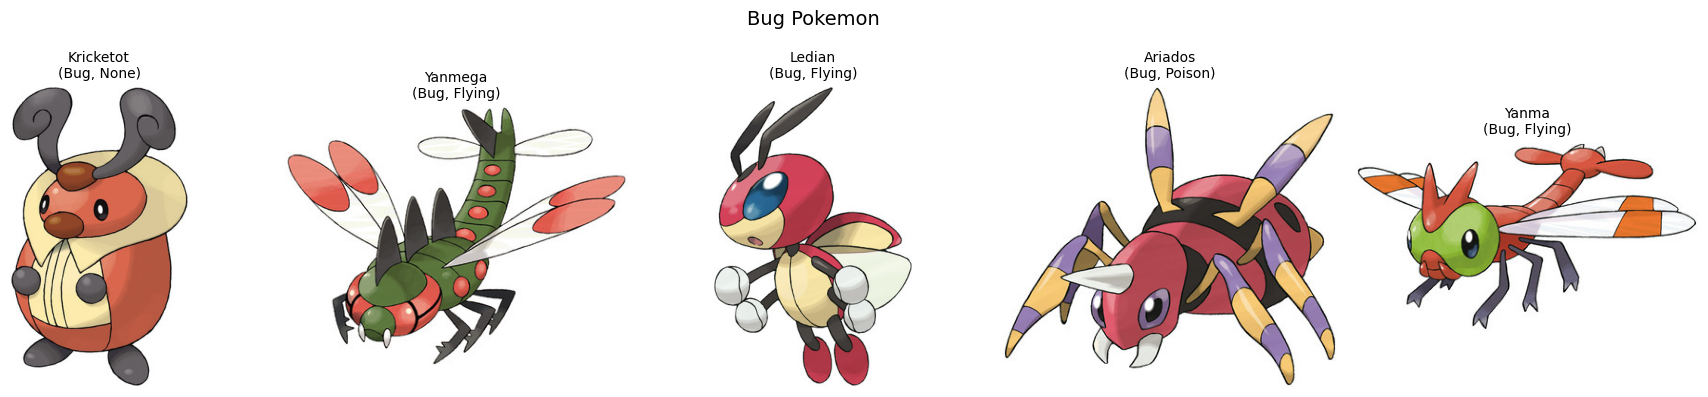

Type Bug hit rate at 5: 1.0


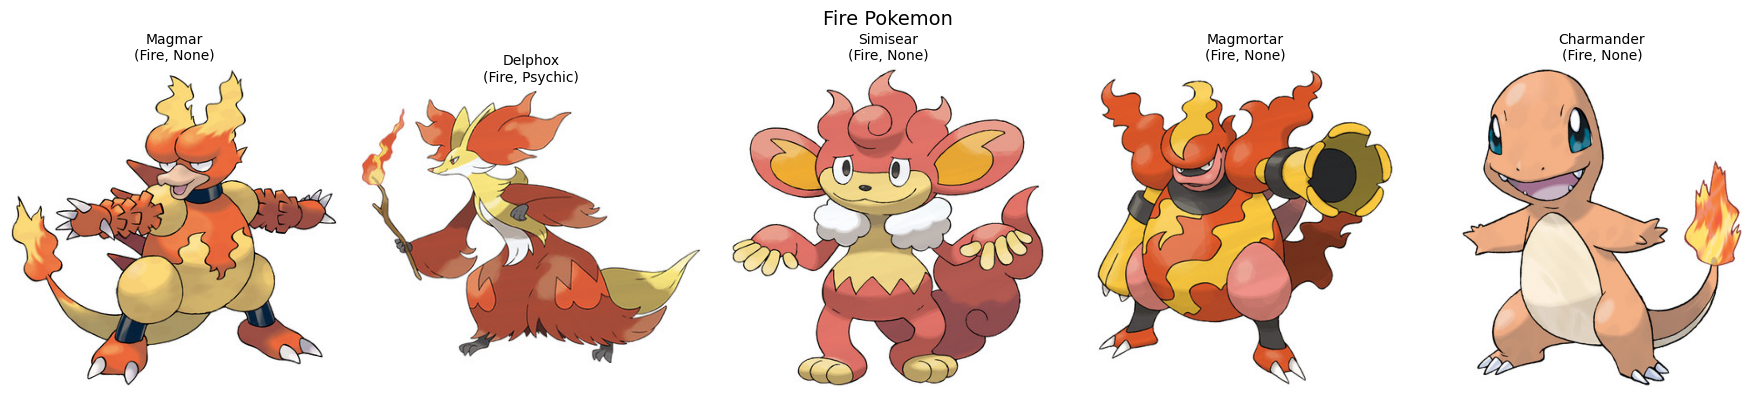

Type Fire hit rate at 5: 1.0


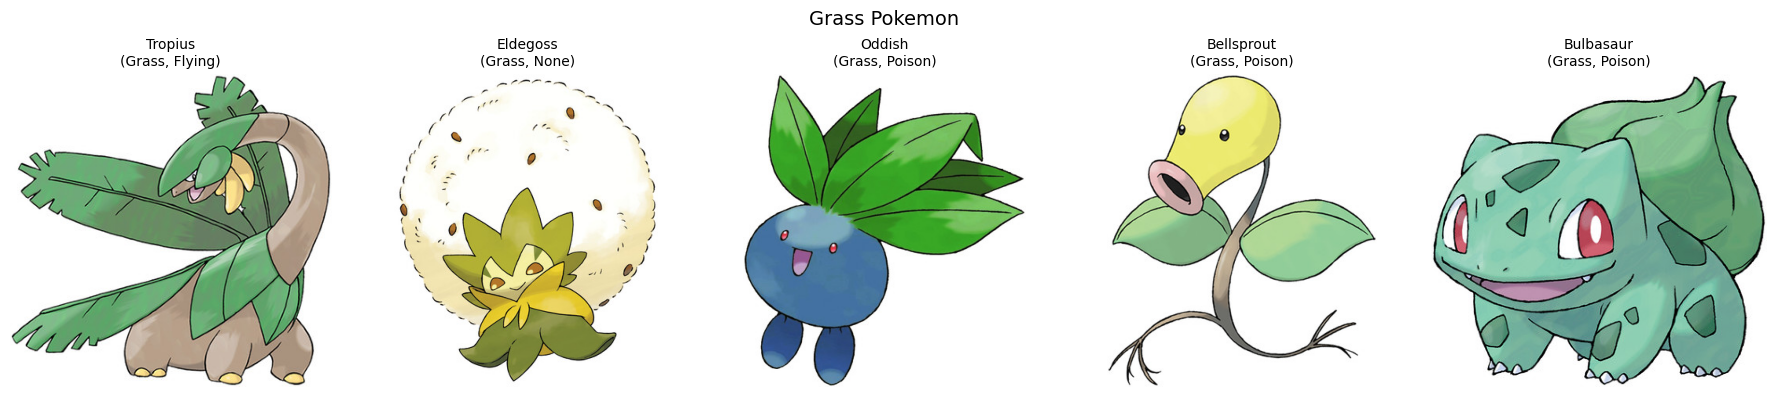

Type Grass hit rate at 5: 1.0


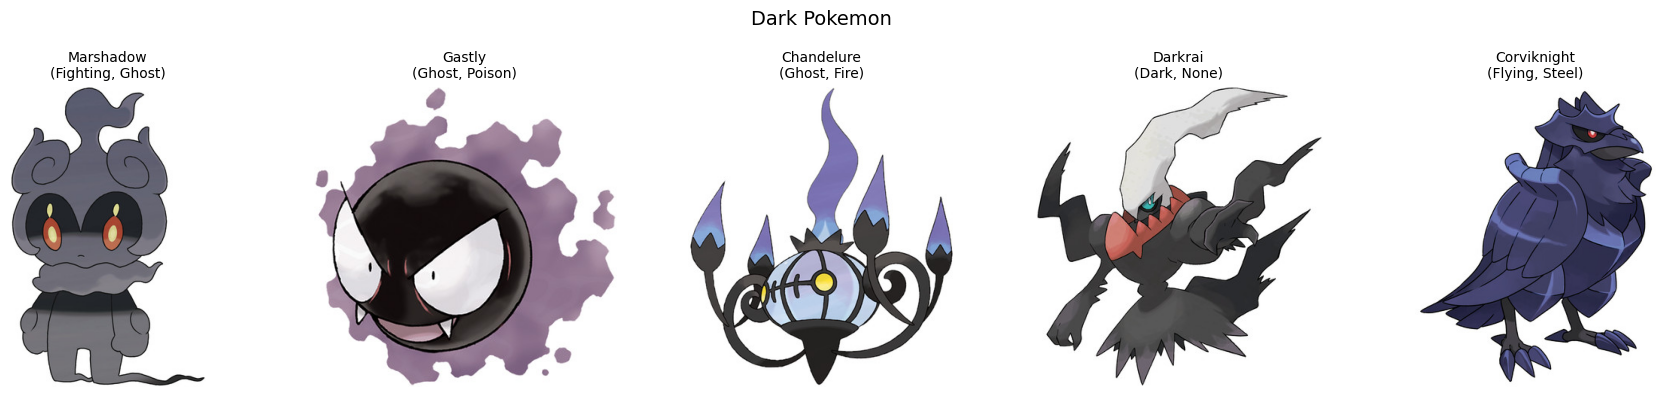

Type Dark hit rate at 5: 0.2


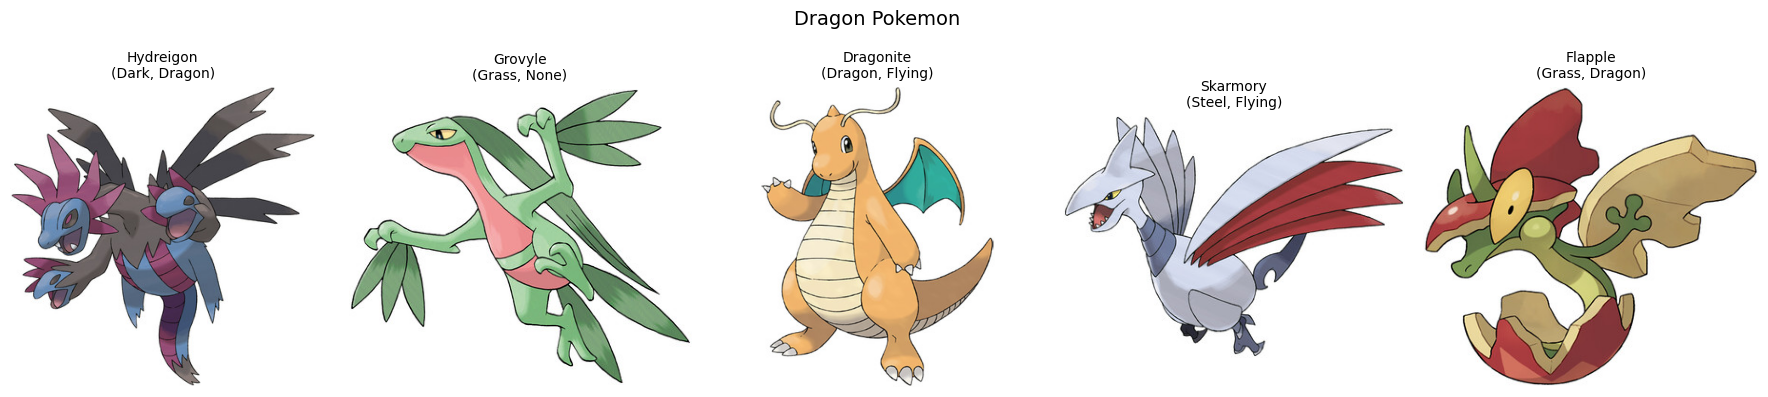

Type Dragon hit rate at 5: 0.6


{'Dark': {'query': 'Dark Pokemon',
  'top_idx': array([666,  59, 499, 391, 687]),
  'scores': array([0.07745, 0.047  , 0.03897, 0.03836, 0.0349 ], dtype=float16),
  'hit@k': 0.2},
 'Dragon': {'query': 'Dragon Pokemon',
  'top_idx': array([523, 191, 100, 167, 705]),
  'scores': array([0.0761 , 0.0651 , 0.0641 , 0.06116, 0.05835], dtype=float16),
  'hit@k': 0.6}}

In [7]:
# By default retrieve the top 5 images according to the text embedding
def retrieve(image_embeds, text_embed, k=5): 
    text_embed = np.atleast_2d(text_embed)
    sims = compute_similarity_image_to_text(image_embeddings=image_embeds, text_embeddings=text_embed)
    scores = sims[:, 0]
    top_idx = np.argsort(-scores)[:k] # score descending order, top k
    return top_idx, scores[top_idx]


def plot_top5(pokedex, top_idx, query):
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    fig.suptitle(query, fontsize=14)

    for ax, idx in zip(axes, top_idx):
        row = pokedex.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        ax.imshow(img)
        t2 = row["Type2"] if row["Type2"] != "" else "None"
        ax.set_title(f'{row["Name"]}\n({row["Type1"]}, {t2})', fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def hit_rate_for_type(pokedex, idx_list, poke_type):
    sub = pokedex.iloc[idx_list]
    return ((sub["Type1"] == poke_type) | (sub["Type2"] == poke_type)).mean()

def evaluate_templates(pokedex, image_embeds, poke_types=("Bug", "Fire", "Grass"), topn=20):
    templates = [
        "A photo of {t} type Pokemon",
        "{t} type Pokemon",
        "A Pokemon of type {t}",
        "{t}",
        "{t} Pokemon"
    ]

    # template -> list of hit rate at k over types
    template_scores = {temp: [] for temp in templates}
    per_type_detail = {temp: {} for temp in templates}

    for t in poke_types:
        for temp in templates:
            query = temp.format(t=t)

            text_embed = clip_inference_text(
                model=model,
                preprocess=preprocess,
                texts=[query],
                device=device,
            )[0]  # (D,)

            top_idx, scores = retrieve(
                image_embeds=image_embeds,
                text_embed=text_embed,
                k=topn,
            )

            hit = hit_rate_for_type(pokedex, top_idx, t)
            template_scores[temp].append(hit)
            per_type_detail[temp][t] = hit

    # select best template with best rit rate
    best_template = max(
        templates,
        key=lambda temp: np.mean(template_scores[temp]),
    )
    best_avg_hit = float(np.mean(template_scores[best_template]))
    per_type_hits = per_type_detail[best_template]

    return best_template, best_avg_hit, per_type_hits, template_scores

def retrieve_and_plot(best_template, poke_types):
    results = {}
    for t in poke_types:
        query = best_template.format(t=t)
        text_embed = clip_inference_text(model=model, preprocess=preprocess, texts=[query], device=device)[0]
        top_idx, scores = retrieve(image_embeds=image_embeds, text_embed=text_embed, k=5)
        plot_top5(pokedex=pokedex, top_idx=top_idx, query=query)
        hit = hit_rate_for_type(pokedex=pokedex, idx_list=top_idx, poke_type=t)
        print(f"Type {t} hit rate at 5: {hit}")
        results[t] = {
            "query": query,
            "top_idx": top_idx,
            "scores": scores,
            "hit@k": float(hit),
        }
    return results

# Template evaluation
best_template, best_avg, per_type_hits, _ = evaluate_templates(
    pokedex,
    image_embeds,
    poke_types=("Bug", "Fire", "Grass"),
    topn=20,
)

print(f"Selected template: {best_template}")
print(f"Average hit rate: {best_avg}")
print(f"Per-type hit rate: {per_type_hits}")

# Retrieve and analyze for the required types
retrieve_and_plot(best_template=best_template, poke_types=("Bug", "Fire", "Grass"))
retrieve_and_plot(best_template=best_template, poke_types=("Dark", "Dragon"))




**Answer Q20**:
- Compared with Fire, Grass and Bug, Dark and Dragon have significantly lower top 5 hit rate. This is probably because of the mismatch between appearnace and type definition: Many Pokémon has dragon-like or dark-looking visual characteristics but are not classified as Dragon or Dark type officially (Grovyle, Chandelure). CLIP tends to retrieve Pokemon based on their visual and semantic resemblance instead of the type labels, leading to the lower top 5 hit rate than Bug, Fire and Grass.

#### Question 21

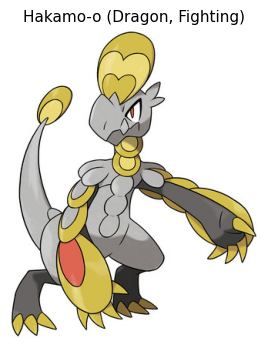

Top5 predicted types:
Normal sim=0.271728515625
Rock sim=0.21484375
Dragon sim=0.208251953125
Ice sim=0.10308837890625
Steel sim=0.0968017578125


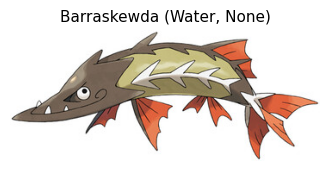

Top5 predicted types:
Normal sim=0.474609375
Water sim=0.311279296875
Dark sim=0.05938720703125
Rock sim=0.0462646484375
Steel sim=0.027618408203125


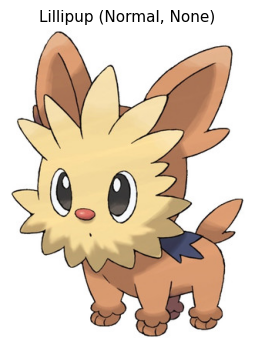

Top5 predicted types:
Normal sim=0.423095703125
Dark sim=0.1331787109375
Fairy sim=0.1290283203125
Rock sim=0.08868408203125
Ice sim=0.06292724609375


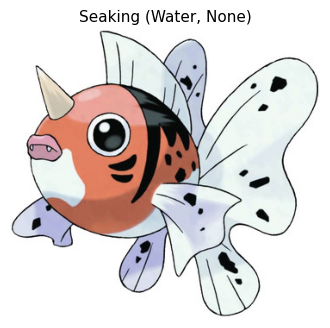

Top5 predicted types:
Normal sim=0.4775390625
Water sim=0.313232421875
Fairy sim=0.08428955078125
Rock sim=0.03515625
Bug sim=0.0203399658203125


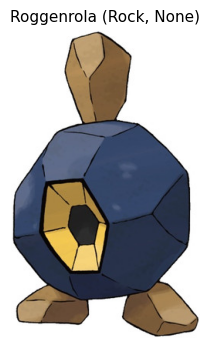

Top5 predicted types:
Rock sim=0.6669921875
Normal sim=0.1253662109375
Dark sim=0.10723876953125
Ice sim=0.0293121337890625
Steel sim=0.0189208984375


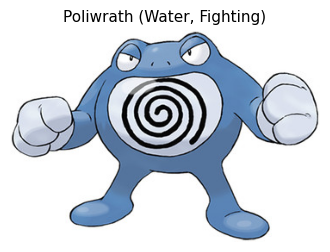

Top5 predicted types:
Poison sim=0.40185546875
Water sim=0.2052001953125
Normal sim=0.13671875
Psychic sim=0.06561279296875
Rock sim=0.045074462890625


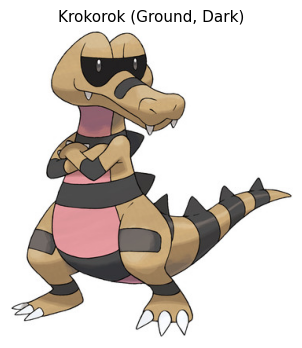

Top5 predicted types:
Rock sim=0.65966796875
Normal sim=0.15185546875
Dark sim=0.054168701171875
Dragon sim=0.04150390625
Ice sim=0.01503753662109375


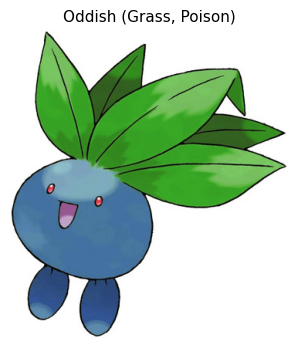

Top5 predicted types:
Poison sim=0.3779296875
Grass sim=0.3720703125
Normal sim=0.1170654296875
Fairy sim=0.052764892578125
Water sim=0.0226898193359375


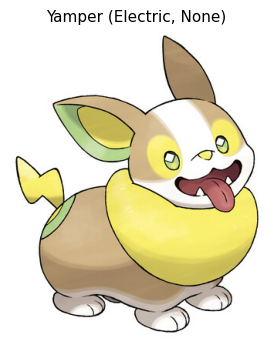

Top5 predicted types:
Normal sim=0.56689453125
Electric sim=0.259521484375
Dark sim=0.037384033203125
Ice sim=0.032989501953125
Fairy sim=0.02490234375


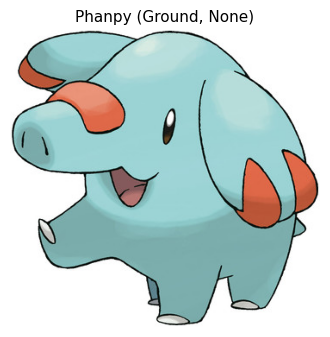

Top5 predicted types:
Normal sim=0.66015625
Ice sim=0.1749267578125
Water sim=0.0202484130859375
Bug sim=0.0178680419921875
Grass sim=0.0175933837890625


In [8]:
def retreive_types(text_embeds, image_embed, k=5):
    image_embed = np.atleast_2d(image_embed)
    sims = compute_similarity_text_to_image(image_embeddings=image_embed, text_embeddings=text_embeds)
    scores = sims[0, :]
    top_idx = np.argsort(-scores)[:k]
    return top_idx, scores[top_idx]

def plot_top5_type(pokedex, idx, pred_types, pred_scores):
    row = pokedex.iloc[idx]
    img = Image.open(row["image_path"]).convert("RGB")

    t2 = row["Type2"]
    if pd.isna(t2) or t2 == "" or t2 == " ":
        t2 = "None"

    title = f'{row["Name"]} ({row["Type1"]}, {t2})'

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title, fontsize=11)
    plt.show()

    print("Top5 predicted types:")
    for t, s in zip(pred_types, pred_scores):
        print(f"{t} sim={float(s)}")

# Randomly choose 10 Pokemons
np.random.seed(0)
rand_idx = np.random.choice(len(pokedex), size=10, replace=False) #choose ten different Pokemon pics

# Prepare the queries
types = (pd.concat([pokedex["Type1"], pokedex["Type2"]]).replace("", np.nan).dropna().unique()) # Need to rule out the impact of None
type_queries = [best_template.format(t=t) for t in types]
type_text_embeds = clip_inference_text(model=model, preprocess=preprocess, texts=type_queries, device=device) # (num_types, D)

for i in rand_idx:
    top_idx, scores = retreive_types(text_embeds=type_text_embeds, image_embed=image_embeds[i], k=5)
    pred_types = [types[j] for j in top_idx]
    plot_top5_type(pokedex=pokedex, idx=i, pred_types=pred_types, pred_scores=scores)


#### Question 22

In [9]:
def get_acc_hit(pokedex, type_text_embeds, image_embeds, k=5):
    correct_top1 = 0
    correct_top5 = 0
    all_top5 = {}
    num_pokes = len(pokedex)
    for i in range(num_pokes):
        top_idx, scores = retreive_types(text_embeds=type_text_embeds, image_embed=image_embeds[i], k=k)
        pred_types = [types[j] for j in top_idx]
        all_top5[i] = pred_types
        type1 = pokedex.iloc[i]["Type1"]

        if type1 == pred_types[0]:
            correct_top1 += 1
        if type1 in pred_types:
            correct_top5 += 1
        
    acc1 = correct_top1 / num_pokes
    hit5 = correct_top5 / num_pokes

    print(f"Acc@1: {acc1}")
    print(f"Hit@5: {hit5}")

    return acc1, hit5, all_top5

acc1, hit5, _ = get_acc_hit(pokedex, type_text_embeds, image_embeds, k=5)

Acc@1: 0.3753315649867374
Hit@5: 0.7360742705570292


#### Question 23

In [ ]:
from huggingface_hub import login
HF_TOKEN = "ENTER YOUR TOKEN HERE" 
login(HF_TOKEN) #Please enter the hugging face token above here to ensure the subsequent model usage

In [ ]:
# VLM setup
!pip install -U git+https://github.com/huggingface/transformers
!pip install -q transformers accelerate qwen-vl-utils


import torch
from transformers import AutoProcessor, Qwen3VLForConditionalGeneration
from PIL import Image


VLM_ID = "Qwen/Qwen3-VL-2B-Instruct"

vlm = Qwen3VLForConditionalGeneration.from_pretrained(
    VLM_ID,
    dtype="auto",
    device_map="auto",
)

processor = AutoProcessor.from_pretrained(VLM_ID)

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-gka96_x4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-gka96_x4
  Resolved https://github.com/huggingface/transformers to commit ae05b2ae619aa28fdfdcb8244009d585b7e1fed7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Loading weights:   0%|          | 0/625 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
import json, re

def build_prompt(candidates):
    return (
        "This is the image of a Pokemon. \n" 
        "You are responsible for choosing single most likely PRIMARY Pokemon type from the candidate list. \n"
        f"Candidates: {candidates}\n\n"
        "You should only return your choice as JSON with no additional explanation, following the format provides subsequently. \n"
        "{\"type1\": \"<one of the candidates>\"}"
    )


@torch.no_grad()
def vlm_infer_func(image_path, prompt, max_new_tokens=64):
    image = Image.open(image_path).convert("RGB")

    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ],
    }]

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt"
    )
    inputs = {k: v.to(vlm.device) for k, v in inputs.items()}

    output_ids = vlm.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=1
    )

    in_ids_batch = inputs["input_ids"]
    output_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(in_ids_batch, output_ids)
    ]

    text = processor.batch_decode(
        output_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]
    return text


def extract_type1(text, debug=False):
    obj = safe_json(text)
    if isinstance(obj, dict) and "type1" in obj:
        return obj["type1"]
    if debug:
        print("Returned non-json object:", text)
    return None


def safe_json(text): # prevent wrong return type from VLM
    if not isinstance(text, str):
        return {"raw": text}

    t = text.strip()
    start = t.find("{")
    end = t.rfind("}")

    if start == -1 or end == -1:
        return {"raw": text}

    t = t[start:end+1]
    # fix trailing commas
    t = re.sub(r",\s*}", "}", t)
    t = re.sub(r",\s*]", "]", t)

    try:
        return json.loads(t)
    except:
        return {"raw": text}
    
from tqdm import tqdm

def run_q23_rerank(pokedex, clip_top5, limit=None, max_new_tokens=64, verbose=0):
    num_pokes = len(pokedex) if limit is None else min(limit, len(pokedex))
    correct = 0
    invalid = 0
    preds = []

    for i in tqdm(range(num_pokes), desc="Q23 VLM reranking"):
        candidates = clip_top5[i]
        clip_top1 = candidates[0]
        img_path = pokedex.iloc[i]["image_path"]

        prompt = build_prompt(candidates)
        raw = vlm_infer_func(img_path, prompt, max_new_tokens=max_new_tokens)
        chosen = extract_type1(raw)

        # must choose from candidates, else fallback
        if chosen not in candidates:
            invalid += 1
            final = clip_top1 #fall back
        else:
            final = chosen

        preds.append(final)

        type1 = pokedex.iloc[i]["Type1"]
        if final == type1:
            correct += 1

        if verbose and i < verbose:
            print("----")
            print("i:", i)
            print("Name:", os.path.basename(img_path))
            print("Ground Truth (Type1):", type1)
            print("Candidates:", candidates)
            print("Raw:", raw)
            print("Chosen:", chosen)
            print("Final:", final)

    rerank_acc1 = correct / num_pokes
    return rerank_acc1, preds, invalid

clip_acc1, clip_hit5, clip_top5 = get_acc_hit(pokedex, type_text_embeds, image_embeds, k=5)
rerank_acc1, preds, invalid_cnt = run_q23_rerank(
    pokedex, clip_top5, limit=None, max_new_tokens=64, verbose=0
)

print("CLIP Acc@1:", clip_acc1)
print("CLIP Hit@5:", clip_hit5)
print("VLM reranked Acc@1:", rerank_acc1)
print("Invalid / fallback count:", invalid_cnt, "out of", len(pokedex))




Acc@1: 0.3753315649867374
Hit@5: 0.7360742705570292


Q23 VLM reranking: 100%|██████████| 754/754 [53:33<00:00,  4.26s/it] 

CLIP Acc@1: 0.3753315649867374
CLIP Hit@5: 0.7360742705570292
VLM reranked Acc@1: 0.45225464190981435
Invalid / fallback count: 0 out of 754


In [ ]:
results = pd.DataFrame({
    "Metric": ["CLIP Acc@1", "CLIP Hit@5", "VLM Acc@1"],
    "Value": [clip_acc1, clip_hit5, rerank_acc1]
})
results

Metric     Value
0  CLIP Acc@1  0.375332
1  CLIP Hit@5  0.736074
2   VLM Acc@1  0.452255

**Answer Q23**:
- **Metrics report**:
    - CLIP Acc@1: 0.3753315649867374
    - CLIP Hit@5: 0.7360742705570292
    - VLM reranked Acc@1: 0.45225464190981435

- **Analysis:**  
    - Reranking by VLM does help in this setting: VLM reranking improves Acc@1 from 0.3753 to 0.4523, which has a relative improvement of approximately 20.5% over CLIP's top-1 accuracy. CLIP is a dual-encoder model trained with a contrastive objective and relies solely on embedding similarity between independently encoded image and text features. As a result, it can often retrieve the correct primary type within top 5 candidates but lacks the reasoning required to reliably rank it as top 1. In contrast, a VLM tokenizes the image into visual tokens and jointly attends over image and text tokens within an LLM, enabling a reasoning and instruction-based decision. Therefore, VLM can better resolve ambiguities among visually similar types.